In [1]:
from pymongo import MongoClient
from datetime import datetime
import pandas as pd

### MongoDB

In [2]:
uri = 'mongodb://localhost/'
db = MongoClient(uri)['vendas']

# Recomendação de produtos - Algoritmos Apriori

In [3]:
# dados de 1 ano
d = datetime.now()
cur = db['venda_pedido'].find({'horario':  {'$gte': datetime(d.year - 1, d.month, d.day)}})

qtd = db['venda_estoque'].count_documents({})
pedi = []
for ped in cur:
  itens = []
  for prod in ped['itens_pedido']:
    id = prod['id']
    while len(itens) < id - 1: itens.append(' - ')
    itens.append(f'P{id:02}')
  while len(itens) < qtd: itens.append(' - ')
  pedi.append(itens)

In [4]:
# visualizar
for a in pedi:
  print(a)

[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P21', ' - ', ' - ', ' - ', ' - ', ' - ', 'P27', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P22', 'P23', 'P24', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P21', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P20', ' - ', ' - ', 'P23', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ']
[' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', ' - ', 'P17', ' - ', 'P19', ' - ', 'P21', ' - ', ' - ', ' - ', ' - ', ' - ', '

In [5]:
from apyori import apriori
# regras = list(apriori(pedi, min_support = 0.0006, min_confidence = 0.3, min_lift = 1))
# regras = list(apriori(pedi, min_support = 0.001, min_confidence = 0.1, min_lift = 1))
regras = list(apriori(pedi, min_support = 0.0008, min_confidence = 0.1, min_lift = 1))
# regras = list(apriori(pedi, min_support = 0.0001, min_confidence = 0, min_lift = 0))
# regras = list(apriori(pedi, min_support = 0.00069, min_confidence = 0, min_lift = 0))

it_a = []
it_b = []
# rule = []
supo = []
conf = []
lift = []
for regra in regras:
  for item in regra[2]:
    if ' - ' not in item[0] and ' - ' not in item[1]:
      # rule.append(f"{', '.join(item[0])} > {', '.join(item[1])}")
      it_a.append(','.join(sorted(item[0])))
      it_b.append(','.join(sorted(item[1])))
      supo.append(regra[1])
      conf.append(item[2])
      lift.append(item[3])

df_apriori = pd.DataFrame({
  'item_a': it_a, 
  'item_b': it_b, 
  # 'regra': rule, 
  'suporte': supo, 
  'confianca': conf, 
  'lift': lift
}).sort_values(
  by = ['lift', 'confianca', 'suporte'], 
  ascending = False).reset_index().rename(columns={ 'index': 'id' })
df_apriori


,id,item_a,item_b,suporte,confianca,lift
0,164,"P20,P21,P25",P05,0.001369,1.000000,85.941176
1,156,P05,"P20,P21,P25",0.001369,0.117647,85.941176
2,160,"P21,P25","P05,P20",0.001369,0.100000,36.525000
3,157,"P05,P20","P21,P25",0.001369,0.500000,36.525000
4,158,"P05,P21","P20,P25",0.001369,0.500000,29.220000
...,...,...,...,...,...,...
176,0,,P19,0.185489,0.185489,1.000000
177,4,,P23,0.173854,0.173854,1.000000
178,1,,P20,0.172485,0.172485,1.000000
179,5,,P24,0.122519,0.122519,1.000000


In [6]:
i = 0
j = i + 60
df_apriori[i:j]

,id,item_a,item_b,suporte,confianca,lift
0,164,"P20,P21,P25",P05,0.001369,1.000000,85.941176
1,156,P05,"P20,P21,P25",0.001369,0.117647,85.941176
2,160,"P21,P25","P05,P20",0.001369,0.100000,36.525000
3,157,"P05,P20","P21,P25",0.001369,0.500000,36.525000
4,158,"P05,P21","P20,P25",0.001369,0.500000,29.220000
5,172,"P19,P26","P22,P28",0.001369,0.181818,24.148760
6,175,"P22,P28","P19,P26",0.001369,0.181818,24.148760
7,159,"P05,P25","P20,P21",0.001369,0.500000,22.136364
8,173,"P19,P28","P22,P26",0.001369,0.250000,21.485294
9,174,"P22,P26","P19,P28",0.001369,0.117647,21.485294


In [7]:
df_apriori.to_dict('records')

[{'id': 164,
  'item_a': 'P20,P21,P25',
  'item_b': 'P05',
  'suporte': 0.0013689253935660506,
  'confianca': 1.0,
  'lift': 85.94117647058823},
 {'id': 156,
  'item_a': 'P05',
  'item_b': 'P20,P21,P25',
  'suporte': 0.0013689253935660506,
  'confianca': 0.11764705882352941,
  'lift': 85.94117647058823},
 {'id': 160,
  'item_a': 'P21,P25',
  'item_b': 'P05,P20',
  'suporte': 0.0013689253935660506,
  'confianca': 0.1,
  'lift': 36.525000000000006},
 {'id': 157,
  'item_a': 'P05,P20',
  'item_b': 'P21,P25',
  'suporte': 0.0013689253935660506,
  'confianca': 0.5,
  'lift': 36.525},
 {'id': 158,
  'item_a': 'P05,P21',
  'item_b': 'P20,P25',
  'suporte': 0.0013689253935660506,
  'confianca': 0.5,
  'lift': 29.220000000000002},
 {'id': 172,
  'item_a': 'P19,P26',
  'item_b': 'P22,P28',
  'suporte': 0.0013689253935660506,
  'confianca': 0.18181818181818182,
  'lift': 24.14876033057851},
 {'id': 175,
  'item_a': 'P22,P28',
  'item_b': 'P19,P26',
  'suporte': 0.0013689253935660506,
  'confianca

In [8]:
db['venda_apriori'].delete_many({})
db['venda_apriori'].insert_many(df_apriori.to_dict('records'))

InsertManyResult([ObjectId('6647f571d1d3d9455f6dc671'), ObjectId('6647f571d1d3d9455f6dc672'), ObjectId('6647f571d1d3d9455f6dc673'), ObjectId('6647f571d1d3d9455f6dc674'), ObjectId('6647f571d1d3d9455f6dc675'), ObjectId('6647f571d1d3d9455f6dc676'), ObjectId('6647f571d1d3d9455f6dc677'), ObjectId('6647f571d1d3d9455f6dc678'), ObjectId('6647f571d1d3d9455f6dc679'), ObjectId('6647f571d1d3d9455f6dc67a'), ObjectId('6647f571d1d3d9455f6dc67b'), ObjectId('6647f571d1d3d9455f6dc67c'), ObjectId('6647f571d1d3d9455f6dc67d'), ObjectId('6647f571d1d3d9455f6dc67e'), ObjectId('6647f571d1d3d9455f6dc67f'), ObjectId('6647f571d1d3d9455f6dc680'), ObjectId('6647f571d1d3d9455f6dc681'), ObjectId('6647f571d1d3d9455f6dc682'), ObjectId('6647f571d1d3d9455f6dc683'), ObjectId('6647f571d1d3d9455f6dc684'), ObjectId('6647f571d1d3d9455f6dc685'), ObjectId('6647f571d1d3d9455f6dc686'), ObjectId('6647f571d1d3d9455f6dc687'), ObjectId('6647f571d1d3d9455f6dc688'), ObjectId('6647f571d1d3d9455f6dc689'), ObjectId('6647f571d1d3d9455f6dc6

# Predição com Prophet

In [9]:
# # dados de 1 ano
# d = datetime.now()
# cur = db['venda_pedido'].find({'horario':  {'$gte': datetime(d.year - 1, d.month, d.day)}})
cur = db['venda_pedido'].find()

df_prophet = pd.DataFrame(cur)[['horario', 'total']].rename(columns={'horario': 'ds', 'total': 'y'}).sort_values(['ds'])
df_prophet

,ds,y
1,2021-01-01 10:12:00,6433.83
2,2021-01-01 13:30:00,2494.21
0,2021-01-01 23:08:00,3795.21
4,2021-01-02 00:34:00,1849.84
3,2021-01-02 13:20:00,3152.99
...,...,...
4836,2024-05-16 22:56:00,115.18
4838,2024-05-17 10:15:00,8855.49
4840,2024-05-17 11:30:00,629.06
4837,2024-05-17 13:06:00,1812.50


In [10]:
from prophet import Prophet

m = Prophet()
m.fit(df_prophet)

Importing plotly failed. Interactive plots will not work.
21:25:22 - cmdstanpy - INFO - Chain [1] start processing
21:25:22 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5201,2025-05-13 15:26:00
5202,2025-05-14 15:26:00
5203,2025-05-15 15:26:00
5204,2025-05-16 15:26:00
5205,2025-05-17 15:26:00


In [12]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5201,2025-05-13 15:26:00,4218.803579,-949.431699,9702.167464
5202,2025-05-14 15:26:00,4116.234683,-1367.386603,9749.252925
5203,2025-05-15 15:26:00,4264.617490,-1239.416005,9731.300208
5204,2025-05-16 15:26:00,4265.807069,-1314.608276,9473.281569
5205,2025-05-17 15:26:00,4167.857515,-1219.096057,9760.414671


/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


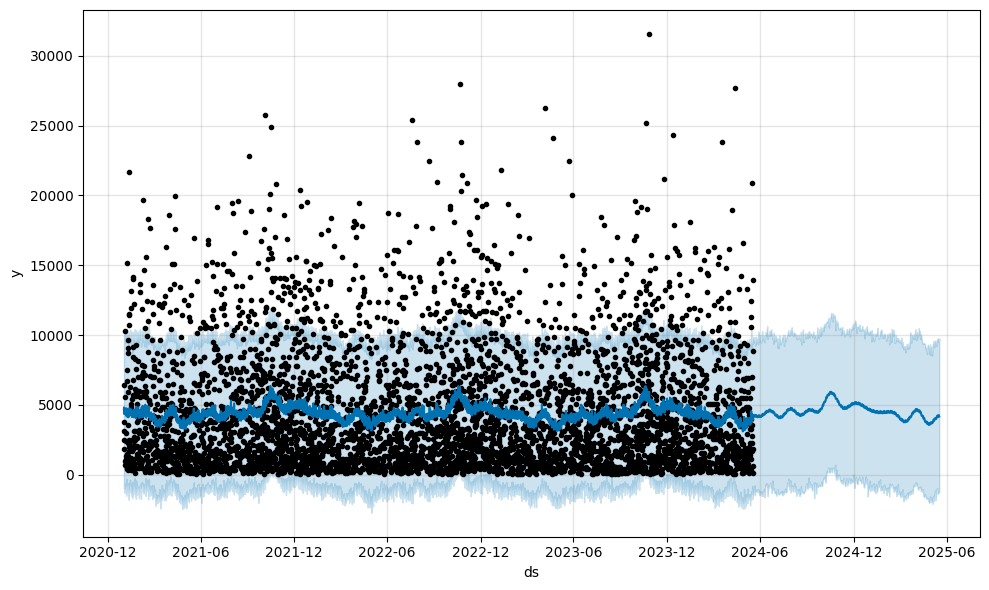

In [13]:
fig1 = m.plot(forecast)

/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/home/oscar/.local/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the o

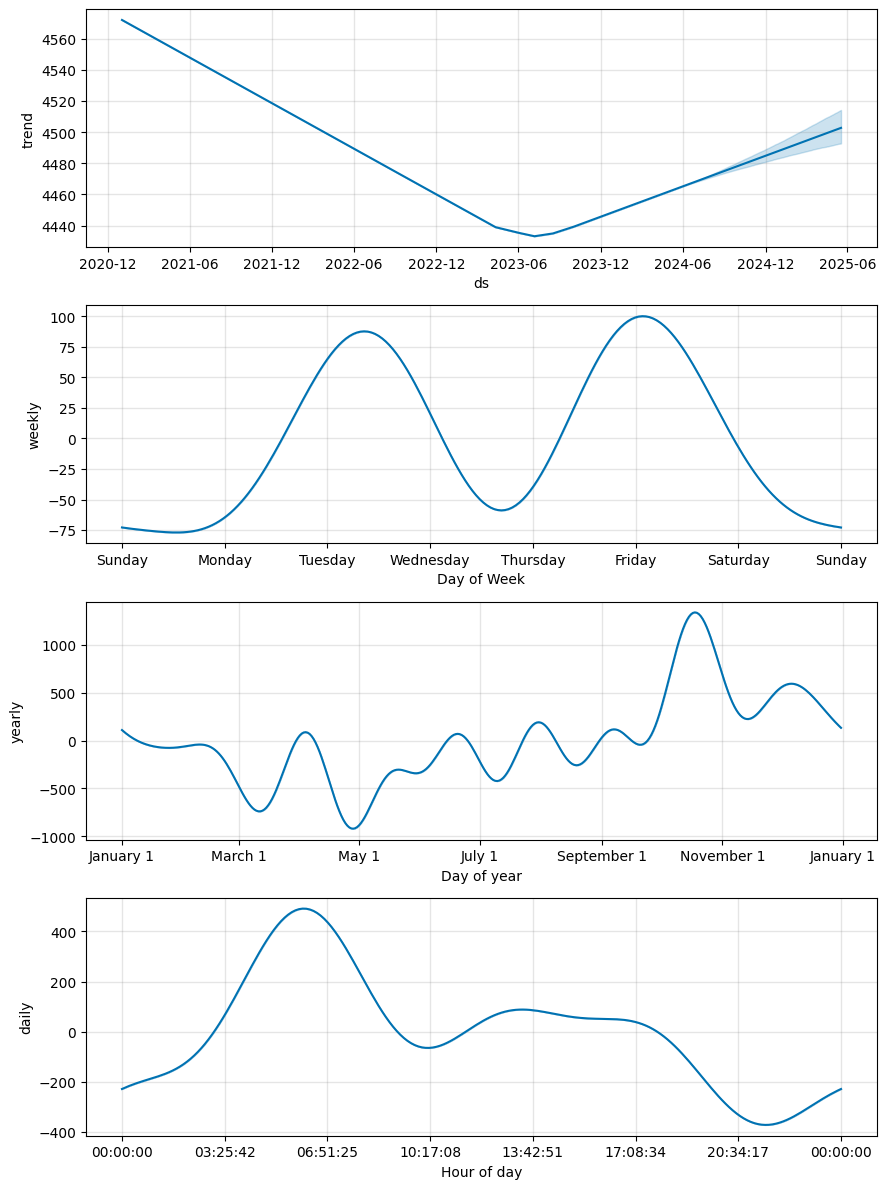

In [14]:
fig2 = m.plot_components(forecast)

In [15]:
fig1.savefig('../home/static/fig1.png')
fig2.savefig('../home/static/fig2.png')